In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import rand_score, silhouette_score, normalized_mutual_info_score
from sklearn.decomposition import PCA

np.random.seed(42)

### Comment
* In python, the speed optimization is not significant (this algorithm may be  even slower) due to the complex implementation of for loops.
* I'm trying to use more numpy operations to speed up, but a few for loops in the kernel steps are hard to avoid. The accelaration will be more obvious if it is implemented in C++.
* Anyway, I believe I implement the correct algorthm and get the expected result, but I don't think it's useful to do tiny optimizations like this in Python.

In [121]:
# kmeans with triangle inequality
def kmeans(X, k=3, max_iter=1000):
	n = X.shape[0]
	key = X[np.random.choice(n, k, replace=False)]
	key_dis = np.linalg.norm(key[:, None, :] - key[None, :, :], axis=2)
	dis = np.linalg.norm(X[:, None, :] - key[None, :, :], axis=2)
	typ = np.argmin(dis, axis=1)
	r = dis[np.arange(n), typ] # possible upper bound upto tentitive center
	l = dis # possible lower bound between all pairs
	for _ in range(max_iter):
		new_key = np.array([np.mean(X[typ == i], axis=0) for i in range(k)])
		dif_key = np.linalg.norm(new_key - key, axis=1)
		key = new_key
		key_dis = np.linalg.norm(key[:, None, :] - key[None, :, :], axis=2)
		if np.all(dif_key < 1e-5):
			break

		# update bounds: by triangle inequality, the change of bounds
		# will not exceed the change of centers.
		l = np.maximum(l - dif_key[None, :], 0)
		r += dif_key[typ]
		
		for i in range(n):
			dis = np.linalg.norm(X[i] - key[typ[i]])
			# main condition of triangle inequality
			# 1) if the lower bound is larger, then ignore it.
			# 2) if the distance between two centers is larger than
			#    the lower bound, then moving to there will not
			#    optimize the clustering.
			for j in np.where((l[i] < r[i]) & (key_dis[typ[i]] < 2 * r[i]))[0]:
				tmp = np.minimum(dis, np.linalg.norm(X[i] - key[j]))
				l[i, j] = tmp
				if tmp < dis:
					typ[i] = j
					dis = tmp
			r[i] = dis
	return typ, key

Testing "seeds.csv"...
Silhouette score: 0.4719337319126887
RI score: 0.8743677375256322
NMI score: 0.6949250270680578


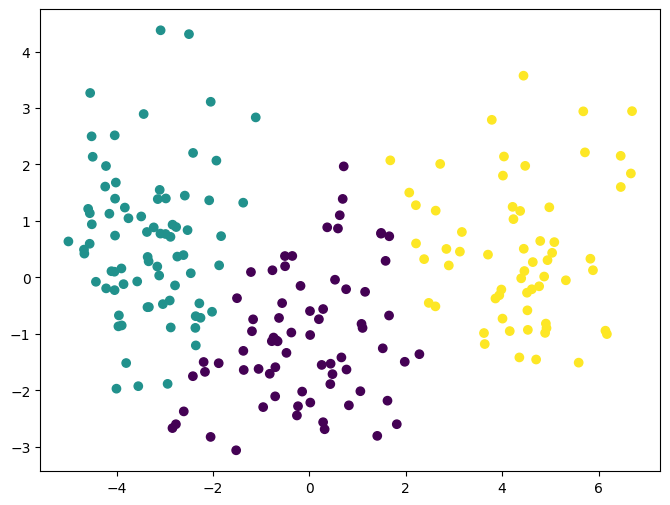

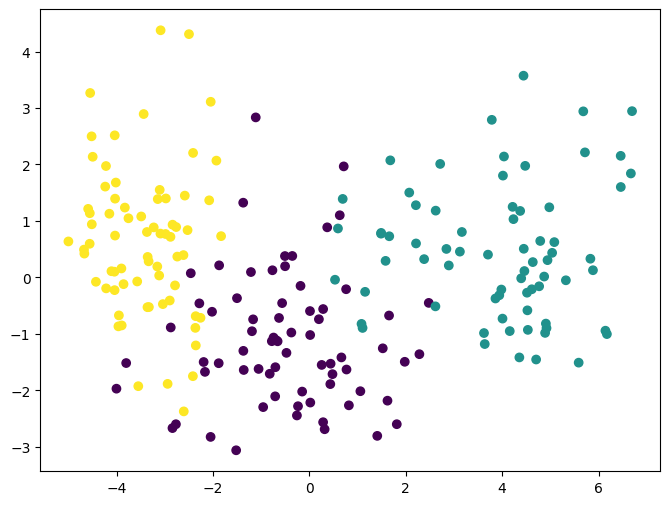

In [122]:
print("Testing \"seeds.csv\"...")
df = pd.read_csv("seeds.csv")
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
typ, key = kmeans(X, 3)
print("Silhouette score:", silhouette_score(X, typ))
print("RI score:", rand_score(y, typ))
print("NMI score:", normalized_mutual_info_score(y, typ))

# plot the clusters by PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=typ)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.show()